# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### Признаки
DateCrawled — дата скачивания анкеты из базы
<br>
VehicleType — тип автомобильного кузова
<br>
RegistrationYear — год регистрации автомобиля
<br>
Gearbox — тип коробки передач
<br>
Power — мощность (л. с.)
<br>
Model — модель автомобиля
<br>
Kilometer — пробег (км)
<br>
RegistrationMonth — месяц регистрации автомобиля
<br>
FuelType — тип топлива
<br>
Brand — марка автомобиля
<br>
Repaired — была машина в ремонте или нет
<br>
DateCreated — дата создания анкеты
<br>
NumberOfPictures — количество фотографий автомобиля
<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)
<br>
LastSeen — дата последней активности пользователя
#### Целевой признак
<br>
Price — цена (евро)

## Подготовка данных

In [115]:
#Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [116]:
#Загрузим датасет
try:
    data=pd.read_csv('C:/Users/ARTEM/Desktop/Project_DS/Тачка на прокачку/autos.csv')    
except:
    data=pd.read_csv('/datasets/autos.csv')
    

In [117]:
#Взглянем на таблицу
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [118]:
#Посмотрим в этом в разрезе
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [119]:
#Посмотрим в этом в разрезе
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [120]:
#Проверим на явные дубликаты
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [121]:
#Сразу их удалим и проверим результат
data=data.drop_duplicates()

data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [122]:
#Год регистрации автомобиля не может быть позже последней даты скачивания из базы
last_datecrawled = pd.to_datetime(data['DateCrawled'])
last_datecrawled.max()

Timestamp('2016-04-07 14:36:58')

In [123]:
#Удалим ненужные строки
data = data.query('1910 < RegistrationYear < 2017')

In [124]:
#Удалим ненужные столбцы, а это DateCrawled,DateCreated,NumberOfPictures,LastSeen,PostalCode
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'],axis = 1)

In [125]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [126]:
#Сразу посмотрим на пропуски
data.isna().sum()

Price                    0
VehicleType          22841
RegistrationYear         0
Gearbox              17834
Power                    0
Model                17562
Kilometer                0
RegistrationMonth        0
FuelType             27174
Brand                    0
Repaired             64712
dtype: int64

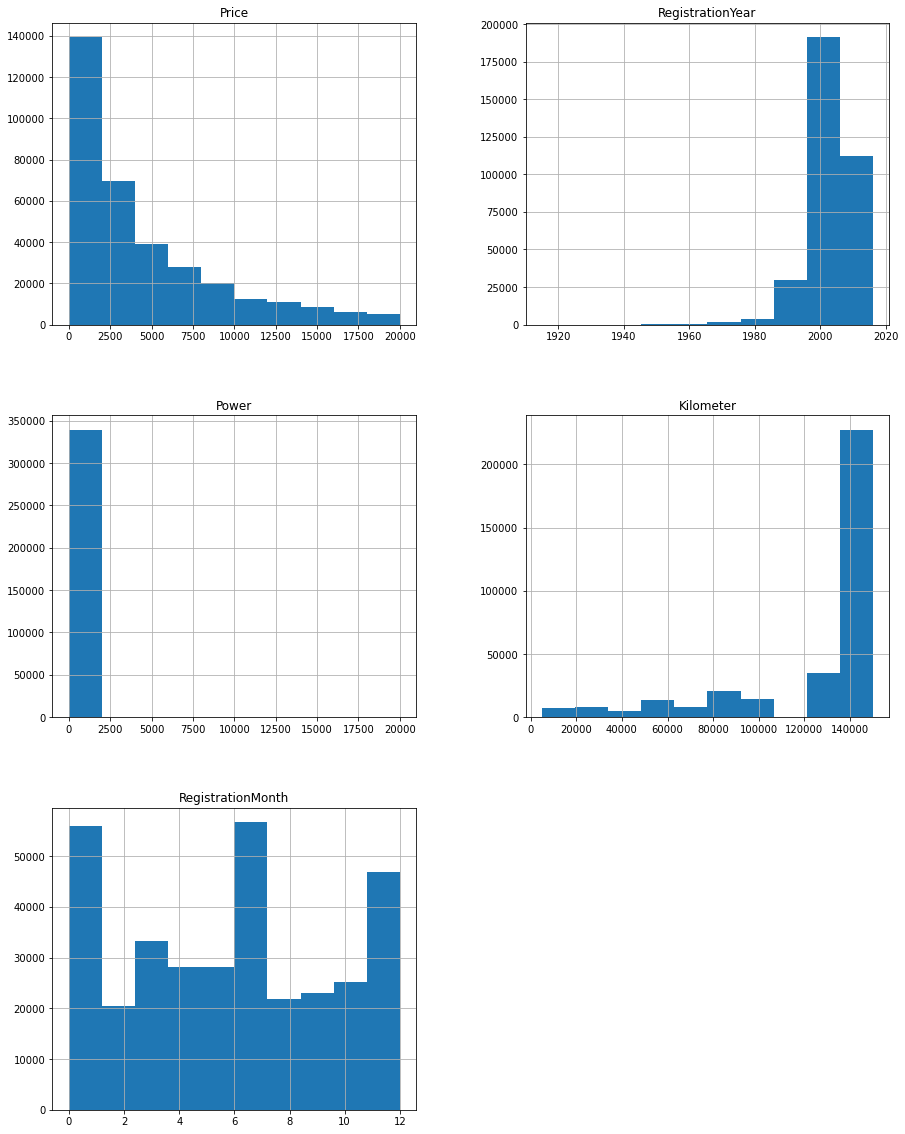

In [127]:
#Посмотрим как распределились значения
data.hist(figsize=(15, 20))
plt.show()

In [128]:
#Месяц регистрации не может быть нулевым
('Кол-во строк для удаления:',len(data[data['RegistrationMonth']==0]))

('Кол-во строк для удаления:', 33540)

In [129]:
data=data[data['RegistrationMonth']>0]

In [130]:
# Цены я хотел поставить меньше 50, но допустим у нас продают машины, которые полностью разрушены за символические доллары
('Кол-во строк для удаления:',len(data[data['Price']==0]))

('Кол-во строк для удаления:', 5816)

In [131]:
data=data[data['Price']>0]

In [132]:
# Перед тем как перейти к мощности форматнем модель, она нам будет нужна в дальнейшем
data['Model'].fillna('unknown',inplace=True)

In [133]:
# Мощность меньше нуля и больше 1000 заполнить средней мощность по моделям, потому что она неправильная. 
#Пока оставим так, но может вообще нужно вначале рассчитать мощность по году регистрации авто и модели и составить новую
data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('mean'))

In [134]:
#Пропуски в типе топлива заменим средними по модели
data['FuelType'] = data['FuelType'].fillna(data.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [135]:
#Пропуски в статусе починки заменю на "Yes", возможно, забывали проставлять
data['Repaired']=data['Repaired'].fillna('yes')

In [136]:
#Пропуски типа коробки заменим также исходя из модели
data['Gearbox'] = data['Gearbox'].fillna(data
                                         .groupby('Model')['Gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [137]:
#Заполним тип авто также неизвестной переменной
data['VehicleType'] = data['VehicleType'].fillna('unknown')

In [138]:
#Проверим
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [139]:
print('Очистка данных составила',round((1-len(data)/354365)*100,2),'%')

Очистка данных составила 15.25 %


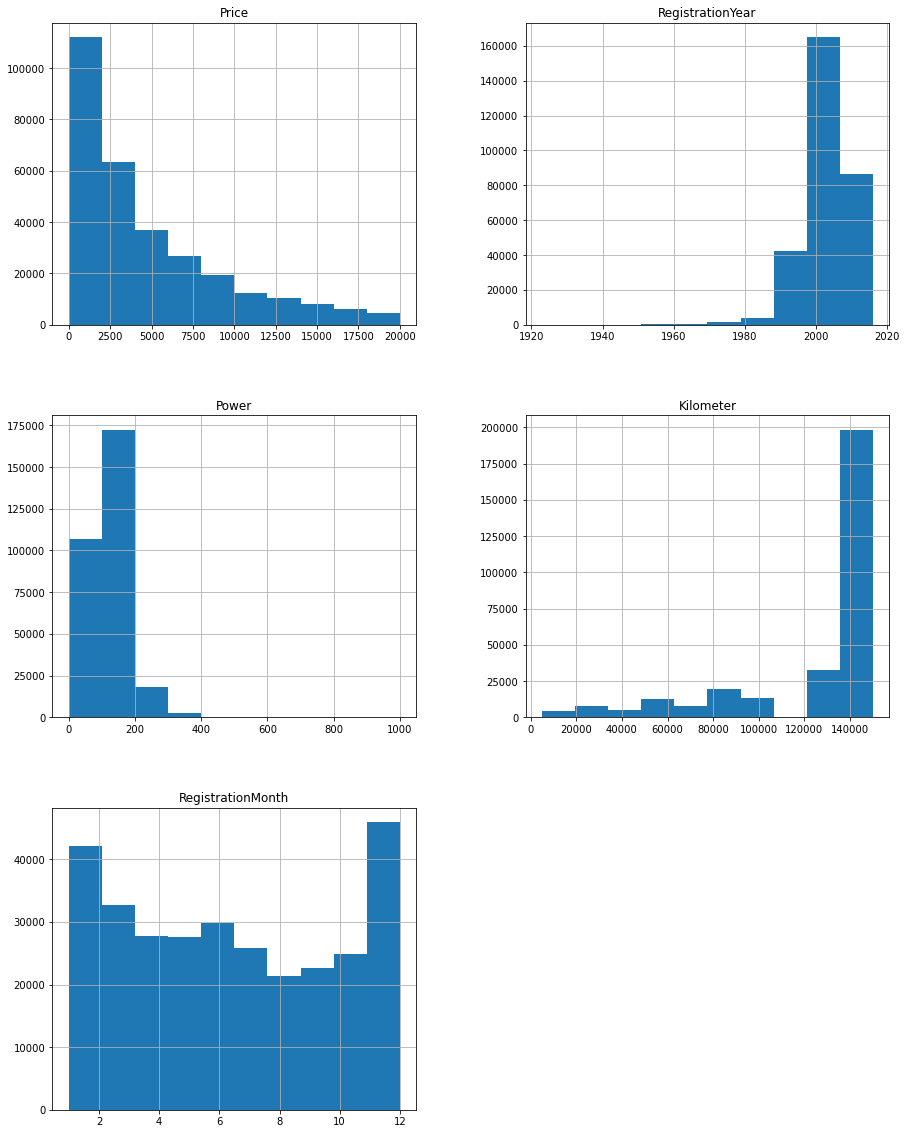

In [140]:
#Посмотрим как распределились значения
data.hist(figsize=(15, 20))
plt.show()

In [141]:
# Переменные типа object переопределим в категориальные
data['VehicleType'] = data['VehicleType'].astype('category')
data['Gearbox'] = data['Gearbox'].astype('category')
data['Model'] = data['Model'].astype('category')
data['FuelType'] = data['FuelType'].astype('category')
data['Brand'] = data['Brand'].astype('category')
data['Repaired'] = data['Repaired'].astype('category');

#### Вывод:
- Проанализированы данные и проведена предобработка
- Удалены лишние столбцы, которые не влияют на прогнозы 'DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'
- Удалены дубликаты
- Заполнены ппропуски
<br>
По итогам предобработки удалено не более 13% исходного датафрейма

## Обучение моделей

In [142]:
# Определим признаки и таргет для обучения

features = data.drop('Price', axis=1) # Копируем данные
target = data['Price']

# Разделим выборку на тренировочные и тестовые данных
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)
print(features.shape)
print(features_train.shape)
print(features_test.shape)

(300312, 10)
(225234, 10)
(75078, 10)


In [143]:
# Применим кодирование категориальных признаков для модели линейной регрессии
features_train_ohe = pd.get_dummies(features_train,drop_first=True)
features_test_ohe = pd.get_dummies(features_test,drop_first=True)


features_train_ohe

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
268557,2007,102.0,125000,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
106820,1997,75.0,150000,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
136849,2004,150.0,150000,12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8249,2003,192.0,150000,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17653,2000,116.0,150000,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141471,1966,189.0,90000,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
305921,1996,211.0,150000,7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
155728,2013,163.0,150000,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
173383,2009,61.0,80000,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [144]:
if len(features_train_ohe.columns.tolist())==len(features_test_ohe.columns.tolist()):
    print('Количество одинаковое')

Количество одинаковое


In [145]:
set(features_train_ohe.columns)-set(features_test_ohe.columns) 

set()

In [146]:
set(features_test_ohe.columns)-set(features_train_ohe.columns)

set()

In [147]:
#Применим порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='error')

category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'] # Запишем категориальные признаки

features_train_oe = features_train
features_test_oe = features_test

features_train_oe[category] = encoder.fit_transform(features_train[category])  # Кодируем категориальные признаки
features_test_oe[category] = encoder.transform(features_test[category])
features_test_oe

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
306223,1.0,2003,0.0,82.000000,188.0,125000,2,6.0,32.0,0.0
317952,4.0,2005,1.0,132.126192,170.0,90000,12,6.0,38.0,0.0
59154,0.0,2003,1.0,150.000000,227.0,150000,8,2.0,27.0,1.0
288979,2.0,2010,0.0,179.000000,30.0,70000,2,6.0,1.0,0.0
3006,4.0,2004,0.0,204.000000,241.0,150000,1,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
140387,5.0,2005,0.0,58.000000,87.0,125000,4,6.0,8.0,0.0
48087,7.0,2007,1.0,120.000000,17.0,150000,4,6.0,19.0,1.0
85440,6.0,2004,0.0,140.000000,208.0,150000,11,2.0,15.0,1.0
207925,1.0,2009,1.0,102.000000,49.0,70000,5,6.0,38.0,0.0


In [148]:
#Обучим модель случайный лес
param = {'n_estimators': range(1,100,10), 'max_depth': range(10,100,10)}
model_rf = RandomForestRegressor(random_state = 12345)
model_rf_cv = RandomizedSearchCV(model_rf, param, scoring = 'neg_mean_squared_error', cv=5, n_iter=3, n_jobs=-1, verbose=1,random_state=12345)



model_rf_cv.fit(features_train_oe, target_train)

print(model_rf_cv.best_params_)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'n_estimators': 31, 'max_depth': 20}


In [149]:
model_rf = RandomForestRegressor(random_state = 12345,n_estimators=31,max_depth=20)
time1= time.time()
model_rf.fit(features_train_oe, target_train)
time2= time.time()
predict = model_rf_cv.predict(features_train_oe)
time3 = time.time()
print("RMSE: ", (model_rf_cv.best_score_*-1)**0.5, 'при', model_rf_cv.best_params_)
print("Время обучения модели:", time2 - time1)
print("Время предсказания модели:", time3 - time2)

RMSE:  1662.4917600862818 при {'n_estimators': 31, 'max_depth': 20}
Время обучения модели: 14.995653867721558
Время предсказания модели: 1.5854434967041016


In [152]:
#Применим модель с градиентным бустингом
model_lgb = LGBMRegressor(random_state=12345)

param_cv = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': range(100, 500, 100),
}

model_lgb_cv = RandomizedSearchCV(model_lgb, param_cv, scoring = 'neg_mean_squared_error', cv=5, n_iter=3, n_jobs=-1, verbose=1,random_state=12345)
model=model_lgb_cv.fit(features_train, target_train)
print(model.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 225234, number of used features: 10
[LightGBM] [Info] Start training from score 4852.613322
{'n_estimators': 400, 'learning_rate': 0.1}


In [153]:
model_lgb=LGBMRegressor(random_state=12345,n_estimators=400,learning_rate=0.1)
time1= time.time()
model_lgb=model_lgb.fit(features_train, target_train)
time2= time.time() 
predict = model.predict(features_train)
time3 = time.time()
print("RMSE: ", (model_lgb_cv.best_score_*-1)**0.5, 'при', model_lgb_cv.best_params_)
print("Время обучения модели:", time2 - time1)
print("Время предсказаний модели на трейне:", time3 - time2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 225234, number of used features: 10
[LightGBM] [Info] Start training from score 4852.613322
RMSE:  1645.927465040808 при {'n_estimators': 400, 'learning_rate': 0.1}
Время обучения модели: 0.857780933380127
Время предсказаний модели на трейне: 0.5515017509460449


In [154]:
#Применим линейную регрессию
model_lr = LinearRegression()

mse = cross_val_score(model_lr, features_train_ohe, target_train, cv=5, scoring='neg_mean_squared_error').mean() * -1 
time1= time.time()
model_lr.fit(features_train_ohe, target_train) 
time2= time.time() 
predict = model_lr.predict(features_train_ohe)
time3 = time.time()
rmse = mse**0.5 

print('RMSE:', rmse)
print("Время обучения модели:", time2 - time1)
print("Время предсказаний модели на трейне:", time3 - time2)

RMSE: 2656.1034342142366
Время обучения модели: 2.021841287612915
Время предсказаний модели на трейне: 0.25923609733581543


## Анализ моделей

In [155]:
result = {'Модель': ['Случайный лес', 'LGBMRegressor', 'Линейная регрессия'],
                  'RMSE': [1915, 1645, 2656], 'Время обучения(сек)':[15, 0.8, 2],
                  'Время предсказания(сек)':[2, 0.5, 0.26]
                 }
result=pd.DataFrame(result)


result.style.hide_index()

C:\Users\ARTEM\AppData\Local\Temp\ipykernel_2228\4181629538.py:8: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  result.style.hide_index()


Модель,RMSE,Время обучения(сек),Время предсказания(сек)
Случайный лес,1915,15.000000,2.000000
LGBMRegressor,1645,0.800000,0.500000
Линейная регрессия,2656,2.000000,0.260000


#### Вывод: Протестируем лучшую модель LGMB и получим финальный резульат

In [156]:
%%time
predict = model.predict(features_test)
rmse = mean_squared_error(target_test, predict) ** 0.5
rmse

CPU times: total: 1.5 s
Wall time: 189 ms


1620.4582260273341

#### Вывод:
Освновными метриками, которые важны заказчику были:
- качество предсказания;
- скорость предсказания;
- время обучения;

По результам нашего исследования лучшее качество показала LGBM, скорорость и время обучения выше чем у линейной регрессии и чем у случайного леса, по времени предсказания аналогичная ситуация
